# architecture-11 ( Basic Regression Wide And Deep Add TA-Lib )
What's new:

1- Change dataset XAGUSD to EURUSD

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, Concatenate, GlobalAveragePooling1D, LayerNormalization
import talib

In [3]:
# === Load and preprocess ===
df = pd.read_csv('datasets-11/EURUSD-H1-rates.csv', sep='\t')

In [4]:
def add_ta_features(df):
    df['rsi'] = talib.RSI(df['<CLOSE>'], timeperiod=14)
    df['macd'], _, df['MACD_hist'] = talib.MACD(df['<CLOSE>'])
    df['ema_50'] = talib.EMA(df['<CLOSE>'], timeperiod=50)
    df['atr'] = talib.ATR(df['<HIGH>'], df['<LOW>'], df['<CLOSE>'], timeperiod=14)
    df['adx'] = talib.ADX(df['<HIGH>'], df['<LOW>'], df['<CLOSE>'], timeperiod=14)
    return df.dropna()


df = add_ta_features(df)

In [5]:
# Scale sequence features
sequence_features = ['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']
wide_features = ['<SPREAD>', '<VOL>', 'adx', 'atr', 'ema_50', 'macd', 'MACD_hist', 'rsi']

scaler_seq = MinMaxScaler()
scaler_wide = MinMaxScaler()
scaler_close = MinMaxScaler()

scaled_seq = scaler_seq.fit_transform(df[sequence_features])
scaled_wide = scaler_wide.fit_transform(df[wide_features])
scaled_close = scaler_close.fit_transform(df[['<CLOSE>']])

# === Create sequences ===
def create_sequences(seq_data, wide_data, target_data, window, horizon):
    X_seq, X_wide, y = [], [], []
    for i in range(window, len(seq_data) - horizon):
        X_seq.append(seq_data[i-window:i])
        X_wide.append(wide_data[i-1])  # use last row of each window
        y.append(target_data[i:i+horizon].flatten())
    return np.array(X_seq), np.array(X_wide), np.array(y)

WINDOW_SIZE = 60
FORECAST_HORIZON = 10

X_seq, X_wide, y = create_sequences(scaled_seq, scaled_wide, scaled_close, WINDOW_SIZE, FORECAST_HORIZON)

# === Train/Test split ===
X_seq_train, X_seq_test, X_wide_train, X_wide_test, y_train, y_test = train_test_split(
    X_seq, X_wide, y, test_size=0.2, shuffle=False
)

# === Build Wide & Deep model ===
def build_wide_deep_model(seq_shape, wide_shape, horizon):
    # Deep part
    seq_input = Input(shape=seq_shape, name="sequence_input")
    x = LSTM(64, return_sequences=True)(seq_input)
    x = LayerNormalization()(x)
    x = GlobalAveragePooling1D()(x)

    # Wide part
    wide_input = Input(shape=wide_shape, name="wide_input")

    # Combine
    combined = Concatenate()([x, wide_input])
    x = Dense(64, activation='relu')(combined)
    x = Dense(32, activation='relu')(x)
    output = Dense(horizon)(x)

    model = Model(inputs=[seq_input, wide_input], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_wide_deep_model(
    seq_shape=(X_seq_train.shape[1], X_seq_train.shape[2]),
    wide_shape=(X_wide_train.shape[1],),
    horizon=FORECAST_HORIZON
)

# === Train ===
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    [X_seq_train, X_wide_train],
    y_train,
    validation_split=0.2,
    epochs=50,
    callbacks=[es],
    verbose=1
)

I0000 00:00:1751130601.916224   27558 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2325 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


Epoch 1/50


I0000 00:00:1751130604.820055   27616 cuda_dnn.cc:529] Loaded cuDNN version 90800


1158/1158 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0126 - mae: 0.0458 - val_loss: 1.3975e-04 - val_mae: 0.0093
Epoch 2/50
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 1.9461e-04 - mae: 0.0105 - val_loss: 5.0673e-04 - val_mae: 0.0205
Epoch 3/50
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.9009e-04 - mae: 0.0104 - val_loss: 1.2499e-04 - val_mae: 0.0089
Epoch 4/50
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 1.5887e-04 - mae: 0.0095 - val_loss: 1.4520e-04 - val_mae: 0.0095
Epoch 5/50
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 1.5570e-04 - mae: 0.0093 - val_loss: 9.8372e-05 - val_mae: 0.0075
Epoch 6/50
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 1.5195e-04 - mae: 0.0091 - val_loss: 8.3700e-05 - val_mae: 0.0068
Epoch 7/50
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.4267e-04 - mae: 0.0088 - val_loss: 1.7327e-04 - val_mae: 0.0109
Epoch 8/50
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 1.4861e-04 - mae: 0.0090 - val_loss: 9.3943e-05 - val_ma

In [6]:
# === Load the last 110 rows from a separate CSV file for prediction ===
input_df = pd.read_csv('datasets-11/new-data-for-test/rows-60-from-20240503/rows-110-from-20240503.csv', sep='\t')

input_df = add_ta_features(input_df)

# Take only the last 60 usable rows after TA features
input_df = input_df.tail(60)

input_seq_scaled = scaler_seq.transform(input_df[sequence_features])
input_wide_scaled = scaler_wide.transform(input_df[wide_features])

input_seq = np.expand_dims(input_seq_scaled, axis=0)
input_wide = np.expand_dims(input_wide_scaled[-1], axis=0)

pred = model.predict([input_seq, input_wide])
prediction = scaler_close.inverse_transform(pred)
print("Next 10 predicted closing prices:", prediction.flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Next 10 predicted closing prices: [1.0718507 1.0711659 1.0715582 1.0716785 1.0723275 1.0700129 1.0724471
 1.0715154 1.0714626 1.0717164]


# plot section

In [7]:
import sys

sys.path.insert(1, '../utils')
import forex_plot_utils
import os

# PARAMETERS
csv1_path = 'datasets-11/new-data-for-test/rows-60-from-20240503/latest-4-for-history.csv'
csv3_path = 'datasets-11/new-data-for-test/rows-60-from-20240503/after.csv'
plot_title = 'Actual vs Predicted Forex Closing Prices'
output_plot_path = None  # e.g., 'output.png'

# LOAD DATA FROM CSVS
historical_df = forex_plot_utils.load_csv_with_datetime(csv1_path) if os.path.exists(csv1_path) else None
actual_future_df = forex_plot_utils.load_csv_with_datetime(csv3_path) if os.path.exists(csv3_path) else None

# LOAD DATA FROM PREDICTION

# Combine <DATE> and <TIME> columns into a datetime
input_df['DATETIME'] = pd.to_datetime(input_df['<DATE>'] + ' ' + input_df['<TIME>'])

last_timestamp = input_df['DATETIME'].iloc[-1]
datetime_index = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=len(prediction[0]), freq='h')

# Create DataFrame
predicted_df = pd.DataFrame({'DATETIME': datetime_index, '<CLOSE>': prediction[0]})

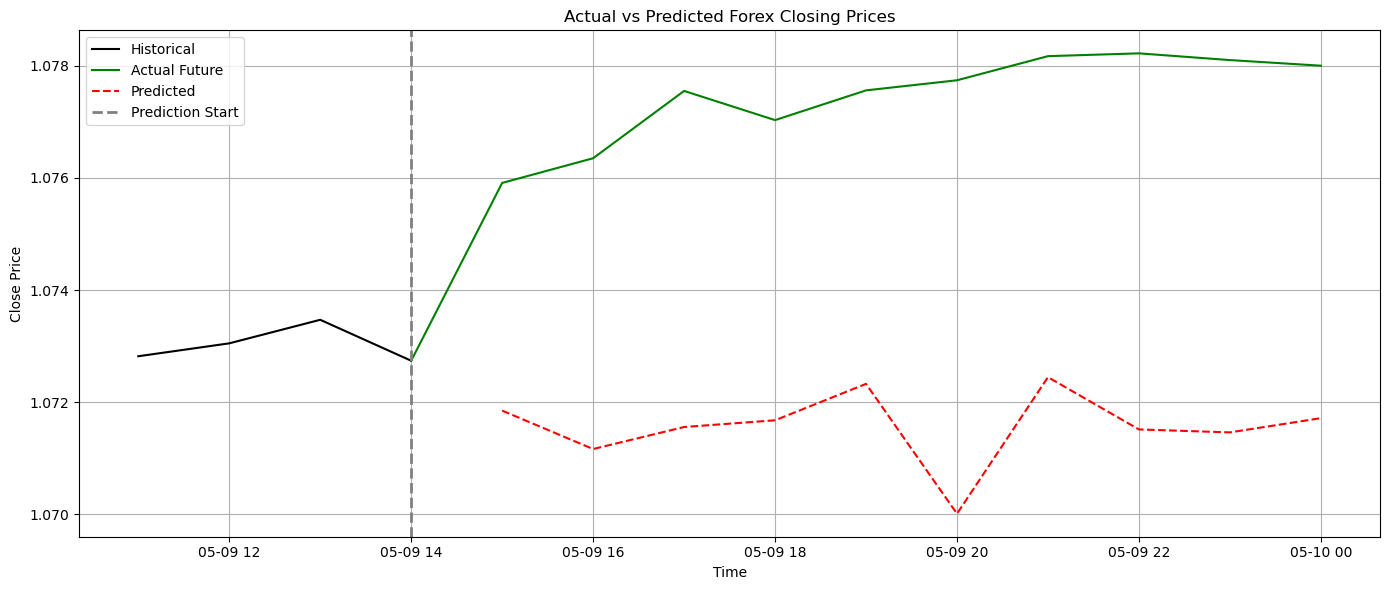

In [8]:
# PLOT
forex_plot_utils.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)

In [9]:
from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

# === Create timestamp and paths ===
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs(log_dir, exist_ok=True)

# === Save model ===
model.save(model_path)

# === Save training history ===
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)

# === Save training loss plot ===
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# === Save model summary and final performance ===
with open(os.path.join(log_dir, 'model_log.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    final_train_loss = history.history['loss'][-1]
    final_test_loss, final_test_mae = model.evaluate([X_seq_test, X_wide_test], y_test, verbose=0)
    f.write(f'\nFinal Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Test Loss : {final_test_loss:.6f}\n')
    f.write(f'Final Test MAE : {final_test_mae:.6f}\n')
